# Optical flow of Goes-16 images

Importing necessary libraries

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os, cv2, math, statistics, datetime
import pylab as pl
import scipy.cluster.hierarchy as sch
import xarray as xr

from mpl_toolkits.basemap import Basemap
from PIL import Image
from matplotlib import cm
from mpl_toolkits.axes_grid1 import ImageGrid
from shutil import copyfile
from sklearn.cluster import AgglomerativeClustering

Setting location names and coordinates

In [ ]:
# List containing the location name, Latitude/Longitude of the surface stations and number which will be displayed on map
locations = [['Brasilia', -15.60083, -47.71306, 1],
             ['Cachoeira Paulista', -22.6896, -45.0062, 2],
             ['Petrolina', -9.0689, -40.3197, 3],
             ['Sao Martinho da Serra', -29.4428, -53.8231, 4]]

## Displaying locations on map

In [ ]:
# Creating map of South America
m = Basemap(llcrnrlon= -75, 
            llcrnrlat= -35,
            urcrnrlon= -28,
            urcrnrlat= 5, 
            epsg= 4618, 
            resolution='h')

# Creating figure
fig, ax = plt.subplots(figsize=(8,8))

# Setting text box text with location names and labels
textstr = ''

for location in locations:
    textstr += str(location[-1]) + ' - ' + location[0]
    
    if location[-1] < len(locations):
        textstr += '\n'

# text box properties
props = dict(boxstyle='square', facecolor='none')

# text box location
ax.text(1.05, 0.99, textstr, transform=ax.transAxes, fontsize=13,
        verticalalignment='top', bbox=props)


# Looping through locations
for location in locations:

    lat_down = location[1] - 1
    lat_up = location[1] + 1

    lon_left = location[2] - 1
    lon_right = location[2] + 1
    
    # Specifying area boundaries
    lons = [lon_left, lon_left, lon_right, lon_right, lon_left]
    lats = [lat_up, lat_down, lat_down, lat_up, lat_up]
    
    # Plotting area on South America map
    x, y = m(lons, lats)
    m.plot(x, y ,'black')
    
    # Writing inside box
    x1, y1 = m(location[2], location[1])
    plt.text(x1, y1, f'{location[3]}', color='black', ha='center', va='center', fontweight='bold', fontsize=14)
    
parallels = np.arange(-55.,15.,10.)
#m.drawparallels(parallels,labels=[True,False,True,False], color='black')
meridians = np.arange(-85.,-25.,10.)
#m.drawmeridians(meridians,labels=[True,False,False,True], color='black')

# the continents will be drawn on top
m.drawmapboundary(fill_color='white')

# fill continents
m.fillcontinents(color='#D6D6D6')
m.drawcoastlines()
m.drawcountries()
#plt.title('Áreas de interesse', fontsize=16)
plt.show()

## Cropping NetCDF files

In [ ]:
# Setting the source files path, this is where all files with the .nc extension are located
path = r"C:\Users\rodri\Documents\Unifesp\Mestrado\Goes\Arquivos inteiros"
directory = os.fsencode(path)
os.chdir(path)

# Looping through locations
for location in locations:
    
    # Looping through every .nc file in the directory
    for file in os.listdir(directory):
        
        # Opening the dataset with xarray library
        ncfile = file.decode('utf-8')
        ds = xr.open_dataset(ncfile)
        
        # Extracting the date from the file
        date = str(ds.attrs['date_created'])
    
        # Selecting the variables
        lon = ds['lon'].values
        lat = ds['lat'].values

        # Setting the value of k, this is the size of our box around the location
        k = 2.0
        
        # Setting the latitude and latitude
        lat_station = location[1]
        lon_station = location[2]
        lat_list = list(lat)
        lon_list = list(lon)
        
        # Finding the closest point in the dataset that matches our location latitude and longitude
        lat_start = lat_list.index(lat_list[min(range(len(lat_list)), key = lambda i: abs(lat_list[i]-(lat_station - k)))])
        lat_end = lat_list.index(lat_list[min(range(len(lat_list)), key = lambda i: abs(lat_list[i]-(lat_station + k)))])
        lon_start = lon_list.index(lon_list[min(range(len(lon_list)), key = lambda i: abs(lon_list[i]-(lon_station - k)))])
        lon_end = lon_list.index(lon_list[min(range(len(lon_list)), key = lambda i: abs(lon_list[i]-(lon_station + k)))])
        
        # Setting the new .nc file with our specified dimensions
        data = ds['CMI'][lat_start:lat_end, lon_start:lon_end]
        
        # Naming our file with the date and time
        file = date[0:4] + '_' + date[5:7] + '_' + date[8:10] + '_' + date[11:13] + date[14:16]
        
        # Saving the cropped NetCDF file
        data.to_netcdf(path=fr"C:\Users\rodri\Documents\Unifesp\Mestrado\Goes\{location[0]}\{file}.nc")
        ds.close()

## Plotting NetCDF Goes-16 images

In [ ]:
for location in locations:
    
    # Setting the source files path, this is where all cropped files with the .nc extension are located
    path = rf"C:\Users\rodri\Documents\Unifesp\Mestrado\Goes\{location[0]}"
    directory = os.fsencode(path)
    os.chdir(path)
    
    # Looping through every cropped .nc file in the directory
    for file in os.listdir(directory):
        
        ncfile = file.decode("utf-8")
        ds = xr.open_dataset(ncfile)

        # Plotting the image
        fig = plt.figure(figsize=(10,10))
        ax = plt.axes(projection=ccrs.PlateCarree())
        mapa = ds['CMI'].plot(ax=ax,transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=False, cmap='gray', vmax=0.8, vmin=0)
        cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
        plt.colorbar(mapa, cax=cax).remove()
        gl = ax.grid(True)

        # Changing the directory to where we wish to save the image
        os.chdir(rf"C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Goes\{location[0]}\Input")
        plt.savefig(file.decode("utf-8")[0:-3] + '.png')
        os.chdir(rf"C:\Users\rodri\Documents\Unifesp\Mestrado\Goes\{location[0]}")
        plt.close()

## Cropping the border out of the .png file

In [ ]:
for location in locations:
    
    path = rf"C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Goes\{location[0]}\Input"
    directory = os.fsencode(path)
    os.chdir(path)

    for file in os.listdir(directory):
        
        # Setting image
        img = file.decode("utf-8")

        # Opens a image in RGB mode 
        im = Image.open(img) 

        # Size of the image in pixels (size of orginal image) 
        # (This is not mandatory) 
        width, height = im.size 

        # Setting the points for cropped image 
        left = 122
        top = 111
        right = 616
        bottom = 605
        
        # Cropped image of above dimension 
        # (It will not change orginal image) 
        im1 = im.crop((left, top, right, bottom)) 

        # Overwriting the file (IT WILL CHANGE THE ORIGINAL IMAGE)
        im1.save(file.decode('utf-8'))

## Calculating the optical flow

In [ ]:
location = 'sms'
month = '10'
frame_folder = rf'C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Dados\Fluxo Otico\{location}\{month}\input'
output_folder = rf'C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Dados\Fluxo Otico\{location}\{month}\output'
input_imgs = []

for file in os.listdir(frame_folder):
    input_imgs.append(file)

print(input_imgs[0], input_imgs[1])

In [ ]:
"""
@author: Lucas R. De Pretto
"""
# Sequential images to be used for the optical flow
frames = [input_imgs[0], input_imgs[1]]

# Forecast window (how many forecasted frames will be generated)
forecast_window = 8

# Algorithm split into 2 loops, the first one goes through all available frames
# The second loop creates forecast images from the previous generated forecast

# Loop 1: available frames
for i in range (1,len(frames)):

    # Setting file path
    nome_frame1 = os.path.join(frame_folder, frames[i-1])
    nome_frame2 = os.path.join(frame_folder,frames[i])
    nome_saida = os.path.join(output_folder, 'FLOWMAP_FRAME{0}-{1}.png'.format(int(i-1), int(i)))
    nome_saida2 = os.path.join(output_folder, 'FORECAST_FRAME{0}.png'.format(int(i+1)))

    # Reading the images
    frame1 = cv2.imread(nome_frame1)
    prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    frame2 = cv2.imread(nome_frame2)
    nxt = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY) 

    # Preparing the flowmap array
    hsv_mask = np.zeros_like(frame1) 
    hsv_mask[..., 1] = 255

    # Applying Farnerback Optical Flow
    flow = cv2.calcOpticalFlowFarneback(prvs, nxt, None, 0.5, 31, 25, 3, 5, 1.2, 0) 

    # Obtaining the magnitude and angle of the displacement vector
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1], angleInDegrees = True) 

    # Creating mask to be used on future frames
    mag_i = mag.astype(int)
    mag_i = np.where(mag_i == 0, 1, 0)

    # Splitting the vectors u and v from the optical flow
    v = flow[...,1]
    u = flow[...,0]

    ub = u
    vb = v

    # Saving the flowmap in 4 directions
    down_mask = np.where((ang > 45) & (ang <=135), 90, 0)
    up_mask = np.where((ang > 225) & (ang <=315), 270, 0)
    left_mask = np.where((ang > 135) & (ang <=225), 180, 0)
    right_mask = np.where((ang > 315) | (ang <=45), 0, 0)
    fin_mask = down_mask + up_mask + left_mask + right_mask

    # Saturating the top 1% of the magnitude to reduce the range of the values
    cutoff = np.percentile(mag, 99)
    mag[mag>cutoff] = cutoff

    # Filling the flowmap array
    hsv_mask[..., 0] = fin_mask    
    hsv_mask[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX) 

    # Converting the flowmap array to RGB and saving
    rgb_representation = cv2.cvtColor(hsv_mask, cv2.COLOR_HSV2BGR) 
    #cv2.imwrite(nome_saida, rgb_representation)


    # Preparing the forecast frame. The multiplication by the magnitude mask allows the filling of the stationary areas,
    # this avoids the overwriting of pixels
    next_frame = frame2[:,:,0] * mag_i

    # Conducting the forecast of the next frame
    # It is necessary to go through each pixel, applying the dispplacement vector
    # Pixels moving outside of the frame and stationary pixels are ignored
    for i in range(frame2.shape[0]):
        for j in range(frame2.shape[1]):

            if (int(ub[i,j]==0) and int(vb[i,j]==0) ):
                continue

            if ((i + int(vb[i,j])) >= next_frame.shape[0]) or ((j + int(ub[i,j])) >= next_frame.shape[1]):
                continue

            next_frame[i + int(vb[i,j]), j + int(ub[i,j])] = frame2[i,j,0]


    # Applying a selective median filter, this removes deformations
    next_frame3 = cv2.medianBlur(next_frame.astype(np.float32), 5)    
    next_frame2 = np.where(next_frame == 0, next_frame3, next_frame)

    # Saving the forecasted frame and preparing the array for the next iteration
    cv2.imwrite(nome_saida2, next_frame2.astype(np.int64))
    next_frame = np.zeros( (next_frame2.shape[0],next_frame2.shape[1], 3) ).astype(int)
    next_frame[...,0] = next_frame2.astype(int)
    next_frame[...,1] = next_frame2.astype(int)
    next_frame[...,2] = next_frame2.astype(int)

# Second loop: additional forecasts
# The amount of iterations is equal to the forecast range
for i in range(forecast_window):

    # Setting file path
    j = i + len(frames)
    nome_saida = os.path.join(output_folder, 'FLOWMAP_FRAME{0}-{1}.png'.format(int(j-1), int(j)))
    nome_saida2 = os.path.join(output_folder, 'FORECAST_FRAME{0}.png'.format(int(j+1)))

    # # Reading the images
    frame1 = frame2.copy()
    frame2 = next_frame.copy()    
    prvs = frame1[...,0]
    nxt = frame2[...,0]

    # Preparing the flowmap array
    hsv_mask = np.zeros((frame1.shape)).astype(np.uint8)
    hsv_mask[..., 1] = 255

    # Applying Farnerback Optical Flow
    flow = cv2.calcOpticalFlowFarneback(prvs, nxt, None, 0.5, 31, 25, 3, 5, 1.2, 0) 

    # Obtaining the magnitude and angle of the displacement vector
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1], angleInDegrees = True) 

    # Creating mask to be used on future frames
    mag_i = mag.astype(int)
    mag_i = np.where(mag_i == 0, 1, 0)

    # Splitting the vectors u and v from the optical flow
    v = flow[...,1]
    u = flow[...,0]    

    ub = u
    vb = v

    # 4 Directions
    down_mask = np.where((ang > 45) & (ang <=135), 90, 0)
    up_mask = np.where((ang > 225) & (ang <=315), 270, 0)
    left_mask = np.where((ang > 135) & (ang <=225), 180, 0)
    right_mask = np.where((ang > 315) | (ang <=45), 0, 0)
    fin_mask = down_mask + up_mask + left_mask + right_mask

    # Saturating the top 1% of the magnitude to reduce the range of the values
    cutoff = np.percentile(mag, 99)
    mag[mag>cutoff] = cutoff

    # Filling the flowmap array
    hsv_mask[..., 0] = fin_mask    
    hsv_mask[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Converting the flowmap array to RGB and saving
    rgb_representation = cv2.cvtColor(hsv_mask, cv2.COLOR_HSV2BGR) 
    #cv2.imwrite(nome_saida, rgb_representation)

    # Preparing the forecast frame. The multiplication by the magnitude mask allows the filling of the stationary areas,
    # this avoids the overwriting of pixels
    next_frame = frame2[:,:,0] * mag_i

    # Conducting the forecast of the next frame
    # It is necessary to go through each pixel, applying the dispplacement vector
    # Pixels moving outside of the frame and stationary pixels are ignored
    for i in range(frame2.shape[0]):
        for j in range(frame2.shape[1]):

            if (int(ub[i,j]==0) and int(vb[i,j]==0) ):
                continue

            if ((i + int(vb[i,j])) >= next_frame.shape[0]) or ((j + int(ub[i,j])) >= next_frame.shape[1]):
                continue

            next_frame[i + int(vb[i,j]), j + int(ub[i,j])] = frame2[i,j,0]

    # Applying a selective median filter, this removes deformations
    next_frame3 = cv2.medianBlur(next_frame.astype(np.float32), 5)    
    next_frame2 = np.where(next_frame == 0, next_frame3, next_frame)

    # Saving the forecasted frame and preparing the array for the next iteration
    cv2.imwrite(nome_saida2, next_frame2.astype(np.int64))
    next_frame = np.zeros( (next_frame2.shape[0],next_frame2.shape[1], 3) ).astype(int)
    next_frame[...,0] = next_frame2.astype(int)
    next_frame[...,1] = next_frame2.astype(int)
    next_frame[...,2] = next_frame2.astype(int)

## Cropping the forecast and real images

We previously set our area of interest sized as a 4x4 square (2 degrees to the right/left and 2 degrees upwards/downwards from our surface station), this was done to reduce the border deformation when applying the optical flow. Now we must set the square size of 2x2, this will be our final setting over our area of interest.

In [ ]:
locations = ['brb', 'cpa', 'ptr', 'sms']
months = ['01', '04', '07', '10']

for location in locations:
    for month in months:
        directory = rf'C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Dados\Fluxo Otico\{location}\{month}\output'
        os.chdir(directory)

        for filename in os.listdir(directory):
            im = Image.open(filename) 

            # Changing dimensions from 4x4 to 2x2
            left = 125
            top = 121
            right = 375
            bottom = 371

            # Cropped image of above dimension 
            # (It will not change orginal image) 
            im = im.crop((left, top, right, bottom)) 

            # Saving the new image (IT WILL CHANGE THE ORIGINAL IMAGE)
            im.save(filename)

for location in locations:
    for month in months:
        directory = rf'C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Dados\Fluxo Otico\{location}\{month}\input'
        os.chdir(directory)

        for filename in os.listdir(directory):
            im = Image.open(filename) 

            # Changing dimensions from 4x4 to 2x2
            left = 125
            top = 121
            right = 375
            bottom = 371

            # Cropped image of above dimension 
            # (It will not change orginal image) 
            im = im.crop((left, top, right, bottom)) 

            # Saving the new image (IT WILL CHANGE THE ORIGINAL IMAGE)
            im.save(filename)

## Plotting a grid of real/forecast images

In [3]:
# Setting locations and months of interest
locations = ['brb', 'cpa', 'ptr', 'sms']
months = ['01', '04', '07', '10']

for location in locations:
    for month in months:
        
        # Setting real files path
        real_path = rf'C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Dados\Fluxo Otico\{location}\{month}\input'

        # Creating list to store real images
        real_imgs = []

        # Setting forecast files path
        forecast_path = rf'C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Dados\Fluxo Otico\{location}\{month}\output'

        # Creating list to store forecast images
        forecast_imgs = []

        # Looping through real files, adding to list
        for file in os.listdir(real_path):
            real_imgs.append(file)

        # Setting date and time according to the second file in the list, which is the second frame used to calculate the optical flow
        date = real_imgs[1][0:-9].replace('_','/')
        time = real_imgs[1][-8:-6] + ':' + real_imgs[1][-6:-4] + ' UTC'

        # Deleting first two files that correspond to the consecutive frames used to generate the forecast
        del real_imgs[0:2]

        # Looping through forecast files, adding to list
        for file in os.listdir(forecast_path):
            forecast_imgs.append(file)

        # Deleting final forecast so we are left with only 8 images
        forecast_imgs.remove('FORECAST_FRAME10.png')

        # List for plot titles
        titles = ['Real t+15', 'Real t+30', 'Real t+45', 'Real t+60',
                 'Previsão t+15', 'Previsão t+30', 'Previsão t+45', 'Previsão t+60',
                 'Real t+75', 'Real t+90', 'Real t+105', 'Real t+120',
                 'Previsão t+75', 'Previsão t+90', 'Previsão t+105', 'Previsão t+120',]

        # Copying and storing images in a single folder, properly ordered
        # New directory
        directory = 'sample'

        # Parent directory
        parent_dir = rf'C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Dados\Fluxo Otico\{location}\{month}'

        # New path
        path = os.path.join(parent_dir, directory)

        # Creating new folder
        os.mkdir(path)

        # Creating lists to store new file prefixes, which will be used to sort real and forecast images and plot them chronologically
        new_file_prefix_1 = ['a_', 'b_', 'c_', 'd_', 'i_', 'j_', 'k_', 'l_']
        new_file_prefix_2 = ['e_', 'f_', 'g_', 'h_', 'm_', 'n_', 'o_', 'p_']

        # Copying real images into new folder
        for i in range(len(real_imgs)):
            new_file_name = new_file_prefix_1[i] + real_imgs[i]
            og_file = rf'C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Dados\Fluxo Otico\{location}\{month}\input\{real_imgs[i]}'
            copy = rf'C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Dados\Fluxo Otico\{location}\{month}\sample\{new_file_name}'
            copyfile(og_file, copy)

        # Copying forecast images into new folder
        for i in range(len(forecast_imgs)):
            new_file_name = new_file_prefix_2[i] + forecast_imgs[i]
            og_file = rf'C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Dados\Fluxo Otico\{location}\{month}\output\{forecast_imgs[i]}'
            copy = rf'C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Dados\Fluxo Otico\{location}\{month}\sample\{new_file_name}'
            copyfile(og_file, copy)
        
        # Creating list with file names
        plot_path = rf'C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Dados\Fluxo Otico\{location}\{month}\sample'
        imgs_name = []
        for file in os.listdir(plot_path):
            imgs_name.append(file)
        imgs_name.sort()
        
        os.chdir(plot_path)
        imgs = []

        # PLOTTING
        for name in imgs_name:
            im = Image.open(name)
            imgs.append(im)
        fig = plt.figure(figsize=(8, 8))
        grid = ImageGrid(fig, 111, 
                         nrows_ncols=(4, 4),  
                         axes_pad=0.25,
                         share_all = True )

        # Deleting axis ticks
        grid[0].get_yaxis().set_ticks([])
        grid[0].get_xaxis().set_ticks([])

        i = 0
        for ax, im in zip(grid, imgs):
            # Iterating over the grid returns the Axes.
            ax.set_title(f"{titles[i]}")
            ax.imshow(im, cmap='gray')
            ax = plt.gca()
            ax.axes.yaxis.set_visible(False)
            i += 1

        fig.suptitle(f'{location} {date} {time}', fontsize=14)
        plt.savefig(f'{location}_{month}.png')
        plt.close()

## Validating forecasts with the Constanza goodness of fit method

In [40]:
### OPTIONAL: MAKE SURE FILES ARE IN 8-bit GRAYSCALE MODE ###
locations = ['brb', 'cpa', 'ptr', 'sms']
months = ['01', '04', '07', '10']

for location in locations:
    for month in months:
        os.chdir(rf'C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Dados\Fluxo Otico\{location}\{month}\sample')
        path = rf'C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Dados\Fluxo Otico\{location}\{month}\sample'
        
        for file in os.listdir(path):
            im = Image.open(file).convert('L')
            im.save(file)
            im.close()

In [ ]:
# Storing fit values
fts_list = []

# Storing z values
z_list = []

# Storing stds
stdevs = []

# Storing fts
random_fts = []

#### INITIAL SETTINGS ###
# Setting location
locations = ['brb', 'cpa', 'ptr', 'sms']
location = locations[1]

months = ['01', '04', '07', '10']
month = months[0]

# Calculating goodness of fit for all forecasts
for i in range(1,9):
    forecast_step = i
    print(f"fit for forecast step {i}...\n")

    # File path
    os.chdir(rf"C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Dados\Fluxo Otico\{location}\{month}\sample")
    path = rf"C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Dados\Fluxo Otico\{location}\{month}\sample"

    files = []

    for file in os.listdir(path):
        files.append(file)

    if forecast_step <= 4:
        real_img = files[forecast_step - 1]
        forecast_img = files[forecast_step + 3]

    else:
        real_img = files[forecast_step + 3]
        forecast_img = files[forecast_step + 7]

    # Real GOES-16 image file
    real = mpimg.imread(real_img)

    # Forecast image file
    forecast = mpimg.imread(forecast_img)
    
    ### COSTANZA STARTS HERE ###
    # PART 1: Calculating the fit for a given forecast scene

    # CATEGORIZING ARRAYS
    # Scene 1: observed GOES-16 image
    # Category 1: overcast
    overcast = (real == 1) * 1

    # Category 2: partial overcast
    partial = ((real > 1) & (real < 0)) * 2

    # Category 3: clear sky
    clear = (real == 0) * 3

    # Joining categories into scene 1
    real_cat = clear + partial + overcast
    real_cat = real_cat[50:200, 50:200]

    # Scene 2: forecast with optical flow (Farnerbäck)
    # Category 1: overcast
    overcast = (forecast == 1) * 1

    # Category 2: partial overcast
    partial = ((forecast > 1) & (forecast < 0)) * 2

    # Category 3: clear sky
    clear = (forecast == 0) * 3

    # Joining categories into scene 2
    forecast_cat = clear + partial + overcast
    forecast_cat = forecast_cat[50:200, 50:200]

    # CALCULATING THE GOODNESS OF FIT
    scene_1 = real_cat.copy()
    scene_2 = forecast_cat.copy()

    # Storing all values from the window w x w contained in the scene
    t = []

    # Storing the mean values of contained in the scene, of each sampling window w x w
    fw = []

    print("Initiating goodness of fit calculations, this might take a while :)\n")

    # Starting the loop, beginning at windows with dimensions 1x1, ending with dimensions of the scene
    for w in range(len(scene_1)):   

        # Creating sub-arrays by sliding through all windows with dimensions w x w contained in the scene
        windows_s1 = np.lib.stride_tricks.sliding_window_view(scene_1, (w+1,w+1))
        windows_s2 = np.lib.stride_tricks.sliding_window_view(scene_2, (w+1,w+1))

        # Associating each sub-array of both scenes by storing them in a tuple
        windows_s = tuple(zip(windows_s1, windows_s2))

        # Looping through all sub-arrays
        for row in range(len(windows_s)):

            for column in range(len(windows_s[0][0])):

                w1 = windows_s[row][0][column]
                w2 = windows_s[row][1][column]

                # Couting how many values of each category are in each sub-array
                s1 = np.array([np.count_nonzero(w1 == 1), np.count_nonzero(w1 == 2), np.count_nonzero(w1 == 3)])
                s2 = np.array([np.count_nonzero(w2 == 1), np.count_nonzero(w2 == 2), np.count_nonzero(w2 == 3)])

                # Storing values in t obtained from the Constanza equation
                t.append(1-(sum(abs(s1-s2)/(2*((w+1)**2)))))

        # Obtaining every fw value by calculating the mean
        fw.append(sum(t)/len(t))

        # Clearing t for further use
        t = []

    # CALCULATING THE FINAL FIT VALUE, FT
    # Defining k, the higher the value, the more weight is given to smaller windows
    k = 0.3

    # Temporary lists to store values for further use
    ft1 = []
    ft2 = []

    for i in range(len(fw)):
        ft1.append(fw[i] * math.exp(-k * ((i + 1) - 1)))
        ft2.append(math.exp(-k * ((i + 1) - 1)))

    # Final fit value, ft
    ft = sum(ft1)/sum(ft2)
    ft_plot = ft
    fts_list.append(ft)


    # Saving values for future plotting
    x = [i for i in range(1,len(scene_1) + 1)]
    y = fw

    print(f"final fit value ft={ft}\n")

    # Calculating runtime
    begin_time = datetime.datetime.now()

    # PART 2: Calculating fit values for 20 shuffled scenes
    # CALCULATING Z
    fts = []

    # Creating random scenes by shuffling the original
    for random_scene in range(0, 20):

        print(f"Calculating fit for random scene {random_scene + 1}")

        scene_2 = real_cat.copy()
        np.random.shuffle(scene_2.ravel())
        scene_2 = scene_2.reshape(scene_1.shape)

        t = []
        fw = []

        # Starting the loop, beginning at windows with dimensions 1x1, ending with dimensions of the scene
        for w in range(len(scene_1)):

            # Creating sub-arrays by sliding through all windows with dimensions w x w contained in the scene
            windows_s1 = np.lib.stride_tricks.sliding_window_view(scene_1, (w+1,w+1))
            windows_s2 = np.lib.stride_tricks.sliding_window_view(scene_2, (w+1,w+1))

            # Associating each sub-array of both scenes by storing them in a tuple
            windows_s = tuple(zip(windows_s1, windows_s2))

            # Looping through all sub-arrays
            for row in range(len(windows_s)):

                for column in range(len(windows_s[0][0])):

                    w1 = windows_s[row][0][column]
                    w2 = windows_s[row][1][column]

                    # Couting how many values of each category are in each sub-array
                    s1 = np.array([np.count_nonzero(w1 == 1), np.count_nonzero(w1 == 2), np.count_nonzero(w1 == 3)])
                    s2 = np.array([np.count_nonzero(w2 == 1), np.count_nonzero(w2 == 2), np.count_nonzero(w2 == 3)])

                    # Storing values in t obtained from the Constanza equation
                    t.append(1-(sum(abs(s1-s2)/(2*((w+1)**2)))))

            # Obtaining every fw value by calculating the mean
            fw.append(sum(t)/len(t))
            t = []

        # CALCULATING THE FINAL FIT VALUE, FT
        # Defining k, the higher the value, the more weight is given to smaller windows
        k = 0.3

        ft1 = []
        ft2 = []

        for i in range(len(fw)):
            ft1.append(fw[i] * math.exp(-k * ((i + 1) - 1)))
            ft2.append(math.exp(-k * ((i + 1) - 1)))

        # Final fit value, ft
        ft = sum(ft1)/sum(ft2)
        fts.append(ft)

    print(f"Fit values: {fts}\n")
    random_fts.append(fts)

    z = (ft/statistics.mean(fts))/statistics.stdev(fts)
    z_list.append(z)
    stdevs.append(statistics.stdev(fts))
    
    print(f"Total run time: {datetime.datetime.now() - begin_time}\n")

    fig, ax = plt.subplots()
    textstr = f'$F_t$ = {round(ft_plot, 2)}\n z = {round(z)}'

    # PART 3: Plotting fit values
    ax.plot(x, y)
    # text box properties
    props = dict(boxstyle='round', facecolor='none', alpha=0.5)

    # text box location
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=13,
            verticalalignment='top', bbox=props)

    plt.ylim(min(y), 1.0)
    plt.ylabel('Ajuste', fontsize=13)
    plt.xlabel('Tamanho da janela', fontsize=13)
    plt.title(f'Ajuste t+{forecast_step * 15}')
    plot_name = f'forecast{forecast_step}'
    plt.savefig(rf'C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Costanza\{location}\{month}\{plot_name}.png')
    plt.close()

fit for forecast step 1...

Initiating goodness of fit calculations, this might take a while :)

final fit value ft=0.9183365011398191

Calculating fit for random scene 1
Calculating fit for random scene 2
Calculating fit for random scene 3
Calculating fit for random scene 4
Calculating fit for random scene 5
Calculating fit for random scene 6
Calculating fit for random scene 7
Calculating fit for random scene 8
Calculating fit for random scene 9
Calculating fit for random scene 10
Calculating fit for random scene 11
Calculating fit for random scene 12
Calculating fit for random scene 13
Calculating fit for random scene 14
Calculating fit for random scene 15
Calculating fit for random scene 16
Calculating fit for random scene 17
Calculating fit for random scene 18
Calculating fit for random scene 19
Calculating fit for random scene 20
Fit values: [0.8593820506445802, 0.8608027198514228, 0.8614174509067586, 0.8623282364453922, 0.8595335644096654, 0.8610111637812221, 0.8595910627700368, 

In [9]:
fts_list

[0.9584512473267893,
 0.9460919379514747,
 0.9398728290515306,
 0.9295517131261624,
 0.9242139973490026,
 0.919812550030105,
 0.9213248410844516,
 0.9185943728304803]

In [10]:
z_list

[1357.6439534033213,
 1887.7709838494798,
 2229.7620817976567,
 1594.9360890077426,
 1864.3229522304862,
 1629.799299140734,
 1408.673182081014,
 1944.5599430959699]

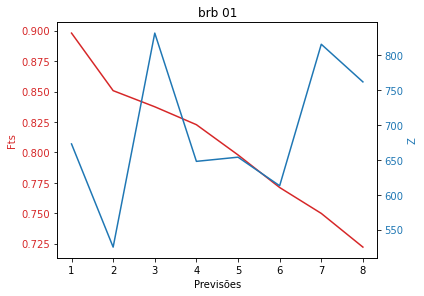

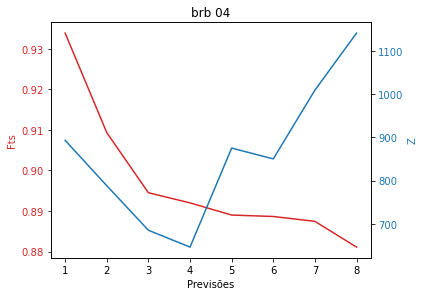

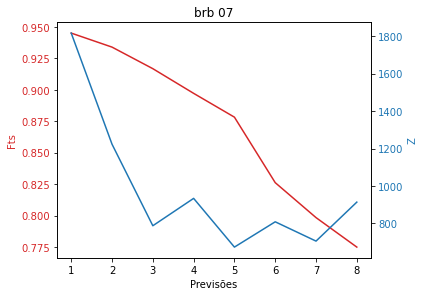

In [6]:
## Storing Ft values
# BRB 01
fts_list_01 = [0.8980139270239916, 0.8507263755849453, 0.8374777083833274, 0.8227601694795086,
            0.7979071892685, 0.771140175573759, 0.7498597249436046, 0.7221837722300041]
z_list_01 = [673, 525, 832, 648, 654, 613, 816, 762]

# BRB 04
fts_list_04 = [0.9338598763568167, 0.9093264708635597, 0.8945134347503942, 0.8920129879308761, 
               0.889017392423865, 0.8886575675459656, 0.887463407682231, 0.8811163014196729]

z_list_04 = [893, 788, 685, 646, 875, 850, 1009, 1141]

# BRB 07
fts_list_07 = [0.945041743240778, 0.9339046681344747, 0.9167692836234069, 0.8971662143033756,
               0.8782426608219721, 0.8261917308745672, 0.7984157671829812, 0.7749806554055233]

z_list_07 = [1816, 1223, 788, 934, 674, 809, 706, 914]
x = [i for i in range(1,9)]

# BRB 10
fts_list_10 = [0.9584512473267893, 0.9460919379514747, 0.9398728290515306, 0.9295517131261624,
               0.9242139973490026, 0.919812550030105, 0.9213248410844516, 0.9185943728304803]

z_list_10 = [1357.6439534033213, 1887.7709838494798, 2229.7620817976567, 1594.9360890077426,
             1864.3229522304862, 1629.799299140734, 1408.673182081014, 1944.5599430959699]


fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Previsões')
ax1.set_ylabel('Fts', color=color)
ax1.plot(x, fts_list_01, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Z', color=color)  # we already handled the x-label with ax1
ax2.plot(x, z_list_01, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('brb 01')
plt.show()

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Previsões')
ax1.set_ylabel('Fts', color=color)
ax1.plot(x, fts_list_04, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Z', color=color)  # we already handled the x-label with ax1
ax2.plot(x, z_list_04, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('brb 04')
plt.show()

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Previsões')
ax1.set_ylabel('Fts', color=color)
ax1.plot(x, fts_list_07, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Z', color=color)  # we already handled the x-label with ax1
ax2.plot(x, z_list_07, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('brb 07')
plt.show()